# Так закаляем сталь

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Исследовательский анализ данных

In [ ]:
# Импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import spearmanr

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загрузка данных
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

except:
    data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/final_steel/data_wire_time.csv')

In [ ]:
# Функция для изучения датасета
def data_info(data):
    data.info()
    display(data.head(5))
    display(data.tail(5))
    display(data.describe())
    print('Дубликатов', data.duplicated().sum())
    print('Пропущенных значений', data.isna().sum())

### Данные об электродах

In [ ]:
data_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
14871  3241  2019-09-01 03:58:58  2019-09-01 04:01:35           0.533670   
14872  3241  2019-09-01 04:05:04  2019-09-01 04:08:04           0.676604   
14873  3241  2019-09-01 04:16:41  2019-09-01 04:19:45           0.733899   
14874  3241  2019-09-01 04:31:51  2019-09-01 04:32:48           0.220694   
14875  3241  2019-09-01 04:34:47  2019-09-01 04:36:08           0.306580   

       Реактивная мощность  
14871             0.354439  
14872             0.523631  
14873             0.475654  
14874             0.145768  
14875             0.196708

key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034             0.637371
max     3241.000000           3.731596             2.676388

Дубликатов 0
Пропущенных значений key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


**Предварительные наблюдения:**
- явных дубликатов или пропущенных значений нет
- для некоторых ключей зарегистрировано несколько наблюдений
- зарегистрировано отрицательное значение реактивной мощности
- тип данных для начала и конца нагрева дугой следует привести к datetime
- наименование столбцов необходимо привести к змеиному регистру латиницей

In [ ]:
# Отсортируем самые низкие значения реактивной мощности
data_arc.sort_values(by='Реактивная мощность').head()

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-24 00:44:48  2019-07-24 00:46:37           0.495782   
5596  1216  2019-06-16 08:22:19  2019-06-16 08:22:30           0.030188   
2419   521  2019-05-22 17:42:57  2019-05-22 17:43:11           0.030563   
4914  1060  2019-06-11 04:31:57  2019-06-11 04:32:08           0.031630   
4633  1000  2019-06-09 01:17:44  2019-06-09 01:17:57           0.038186   

      Реактивная мощность  
9780          -715.504924  
5596             0.020806  
2419             0.021154  
4914             0.022485  
4633             0.022983

In [ ]:
# Проверим показатели по ключу выброса 2116
data_arc[data_arc['key']==2116].value_counts()

key   Начало нагрева дугой  Конец нагрева дугой  Активная мощность  Реактивная мощность
2116  2019-07-24 00:29:52   2019-07-24 00:31:54  0.433266            0.306141              1
      2019-07-24 00:35:50   2019-07-24 00:38:05  0.620265            0.408352              1
      2019-07-24 00:44:48   2019-07-24 00:46:37  0.495782           -715.504924            1
      2019-07-24 00:51:51   2019-07-24 00:52:58  0.299368            0.198796              1
dtype: int64

<b>Вывод:</b> Такой аномально большой выброс подлежит удалению вместе с другими показателя по данному ключу (key=2116).

Text(0.5, 0, 'Активная мощность')

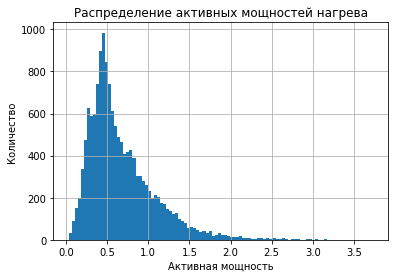

In [ ]:
plt.figure()
ax = data_arc['Активная мощность'].hist(bins=100)
ax.set_title('Распределение активных мощностей нагрева')
ax.set_ylabel('Количество')
ax.set_xlabel('Активная мощность')

Распределение смещено вправо: медиана меньше среднего.

<AxesSubplot:xlabel='Активная мощность'>

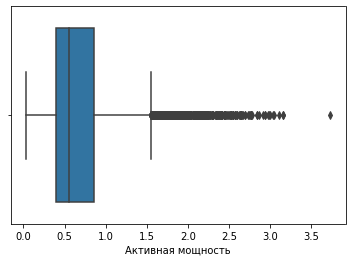

In [ ]:
# Боксплот для распределения активных мощностей
sns.boxplot(data_arc['Активная мощность'])

Text(0.5, 0, 'Реактивная мощность')

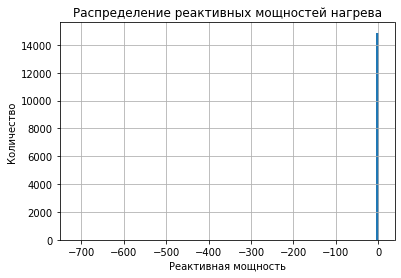

In [ ]:
plt.figure()
ax = data_arc['Реактивная мощность'].hist(bins=100)
ax.set_title('Распределение реактивных мощностей нагрева')
ax.set_ylabel('Количество')
ax.set_xlabel('Реактивная мощность')

<AxesSubplot:xlabel='Реактивная мощность'>

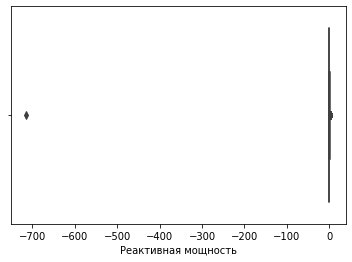

In [ ]:
# Боксплот для распределения реактивных мощностей
sns.boxplot(data_arc['Реактивная мощность'])

Экстремальный отрицательный выброс требует немедленного удаления.

### Данные о подаче сыпучих материалов (объем)

In [ ]:
data_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
3124  3237     NaN     NaN   170.0     NaN     NaN     NaN     NaN     NaN   
3125  3238     NaN     NaN   126.0     NaN     NaN     NaN     NaN     NaN   
3126  3239     NaN     NaN     NaN     NaN     NaN   114.0     NaN     NaN   
3127  3240     NaN     NaN     NaN     NaN     NaN    26.0     NaN     NaN   
3128  3241     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
3124     NaN      NaN      NaN    252.0      NaN    130.0    206.0  
3125     NaN      NaN      NaN    254.0      NaN    108.0    106.0  
3126     NaN      NaN      NaN    158.0      NaN    270.0     88.0  
3127     NaN      NaN      NaN      NaN      NaN    192.0     54.0  
3128     NaN      NaN      NaN      NaN      NaN    180.0     52.0

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

Дубликатов 0
Пропущенных значений key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


array([[<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>]], dtype=object)

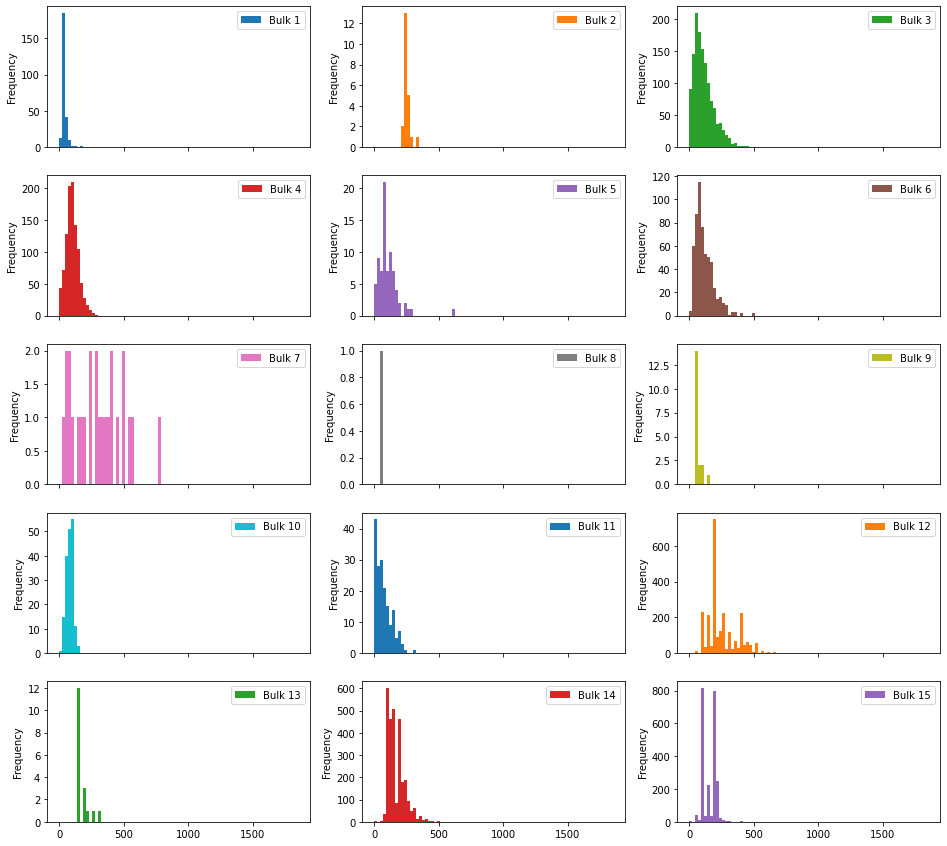

In [ ]:
# Распределения подачи сыпучих материлов
data_bulk.drop(['key'], axis=1).plot.hist(subplots=True, layout=(5,3), figsize=(16, 15), bins=80)

**Предварительные наблюдения**

Распределения подачи сыпучих материалов не похожи на классические нормальные: есть пики и в большей части распределения смещены вправо.

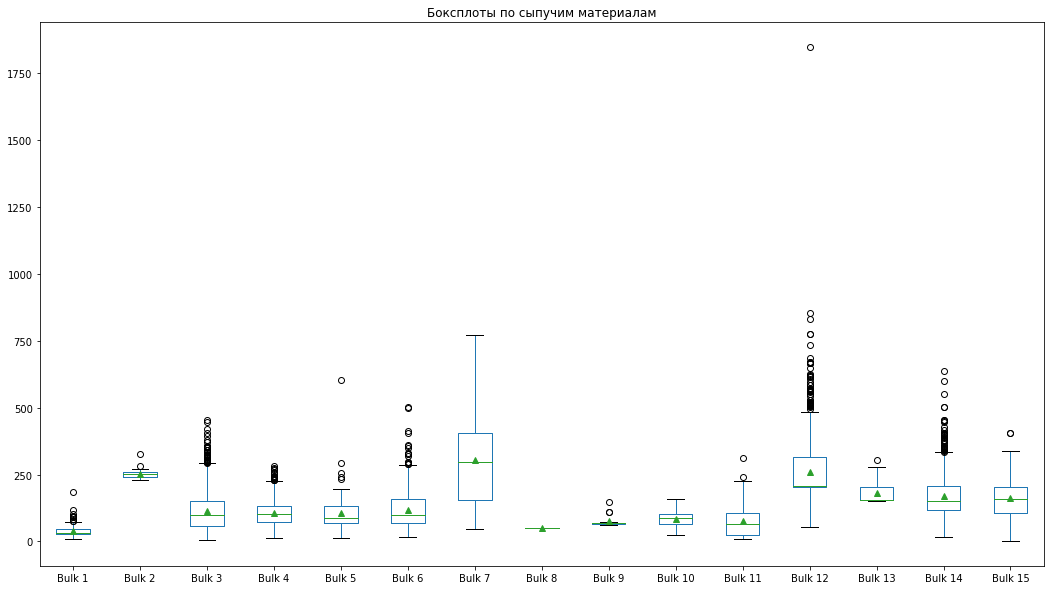

In [ ]:
# Боксплоты по подаче сыпучих материлов
data_bulk.drop(['key'],axis=1).plot(kind='box', figsize=(18,10), title='Боксплоты по сыпучим материалам', showmeans=True)
plt.show()

Наблюдаются аномальные выбросы у Bulk 5 и Bulk 12.

**Предварительные наблюдения:**
- много пропущенных значений, которые могут быть связаны с неподачей сыпучего материала - можно заполнить нулями
- по графикам подачи наблюдаем, что 5 сыпучих материалов чаще используются, чем остальные
- наименование столбцов необходимо привести к змеиному регистру

### Данные о подаче сыпучих материалов (время)

In [ ]:
data_info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56

key Bulk 1 Bulk 2               Bulk 3 Bulk 4 Bulk 5  \
3124  3237    NaN    NaN  2019-08-31 22:51:28    NaN    NaN   
3125  3238    NaN    NaN  2019-08-31 23:39:11    NaN    NaN   
3126  3239    NaN    NaN                  NaN    NaN    NaN   
3127  3240    NaN    NaN                  NaN    NaN    NaN   
3128  3241    NaN    NaN                  NaN    NaN    NaN   

                   Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11  \
3124                  NaN    NaN    NaN    NaN     NaN     NaN   
3125                  NaN    NaN    NaN    NaN     NaN     NaN   
3126  2019-09-01 01:51:58    NaN    NaN    NaN     NaN     NaN   
3127  2019-09-01 03:12:40    NaN    NaN    NaN     NaN     NaN   
3128                  NaN    NaN    NaN    NaN     NaN     NaN   

                  Bulk 12 Bulk 13              Bulk 14              Bulk 15  
3124  2019-08-31 22:46:52     NaN  2019-08-31 22:46:52  2019-08-31 22:46:52  
3125  2019-08-31 23:33:09     NaN  2019-08-31 23:33:09  2019-08-31 23:33:09  
3126  2019-09-01 01:39:41     NaN  2019-09-01 01:33:25  2019-09-01 01:33:25  
3127                  NaN     NaN  2019-09-01 02:41:27  2019-09-01 02:41:27  
3128                  NaN     NaN  2019-09-01 04:05:34  2019-09-01 04:05:34

key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000

Дубликатов 0
Пропущенных значений key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


**Предварительные наблюдения:**
- много пропущенных значений, вероятно зарегистрированных в те же моменты времени, что и в датасете по объему сыпучих материалов. Проверим чуть позднее и заполним нулями
- для дальнейшей работы данные датасета необходимо привести к типу datetime
- наименование столбцов необходимо привести к змеиному регистру

### Данные о продувке сплава газом

In [ ]:
data_info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

key      Газ 1
3234  3237   5.543905
3235  3238   6.745669
3236  3239  16.023518
3237  3240  11.863103
3238  3241  12.680959

key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

Дубликатов 0
Пропущенных значений key      0
Газ 1    0
dtype: int64


Text(0.5, 0, 'Объем поступающего на продувку газа')

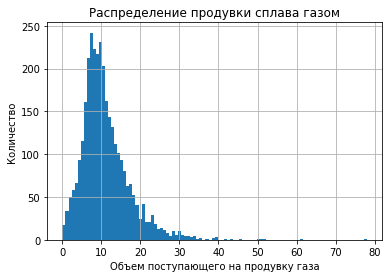

In [ ]:
# Гистограмма распределения продувки сплава газом
plt.figure()
ax = data_gas['Газ 1'].hist(bins=100)
ax.set_title('Распределение продувки сплава газом')
ax.set_ylabel('Количество')
ax.set_xlabel('Объем поступающего на продувку газа')

Распределение смещено вправо: медиана меньше среднего.

<AxesSubplot:xlabel='Газ 1'>

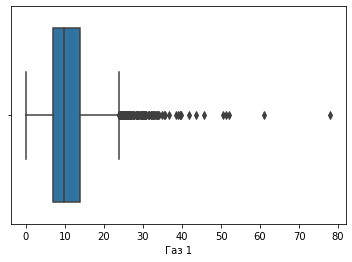

In [ ]:
# "Ящик с усами" для распределения продувки сплава газом
sns.boxplot(data_gas['Газ 1'])

**Предварительные наблюдения:**
- самый полный датасет без пропусков, дубликатов и аномалий
- наименование столбцов необходимо привести к змеиному регистру

### Результаты измерения температуры 

In [ ]:
data_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0

key         Время замера  Температура
15902  3241  2019-09-01 04:03:30       1586.0
15903  3241  2019-09-01 04:16:12          NaN
15904  3241  2019-09-01 04:22:39          NaN
15905  3241  2019-09-01 04:33:42          NaN
15906  3241  2019-09-01 04:38:08          NaN

key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000

Дубликатов 0
Пропущенных значений key                0
Время замера       0
Температура     2901
dtype: int64


Text(0.5, 0, 'Измеренная температура')

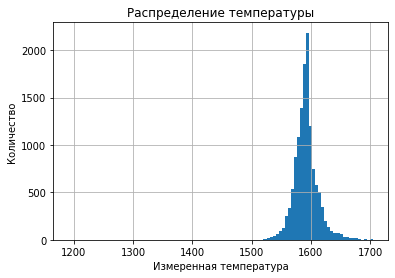

In [ ]:
# Гистограмма распределения температур
plt.figure()
ax = data_temp['Температура'].hist(bins=100)
ax.set_title('Распределение температуры')
ax.set_ylabel('Количество')
ax.set_xlabel('Измеренная температура')

<AxesSubplot:xlabel='Температура'>

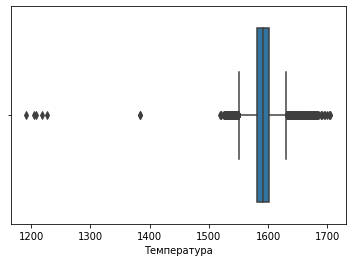

In [ ]:
# Ящик с усами для распределения температур
sns.boxplot(data_temp['Температура'])

Распределение ассиметричное со смещением выбросов влево. Причиной могут быть выбросы ниже температуры плавления стали.

**Предварительные наблюдения:**
- много пропущенных значений по температуре
- минимальная зарегистрированная температура (1191) ниже температуры плавления стали (1300-1500)
- данные столбца "Время замера" следует привести к типу datetime
- наименование столбцов необходимо привести к змеиному регистру

### Данные о проволочных материалах (объем)

In [ ]:
data_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

key      Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
3076  3237   38.088959     NaN     NaN     NaN     NaN     NaN     NaN   
3077  3238   56.128799     NaN     NaN     NaN     NaN     NaN     NaN   
3078  3239  143.357761     NaN     NaN     NaN     NaN     NaN     NaN   
3079  3240   34.070400     NaN     NaN     NaN     NaN     NaN     NaN   
3080  3241   63.117595     NaN     NaN     NaN     NaN     NaN     NaN   

      Wire 8  Wire 9  
3076     NaN     NaN  
3077     NaN     NaN  
3078     NaN     NaN  
3079     NaN     NaN  
3080     NaN     NaN

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

Дубликатов 0
Пропущенных значений key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


array([[<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>]], dtype=object)

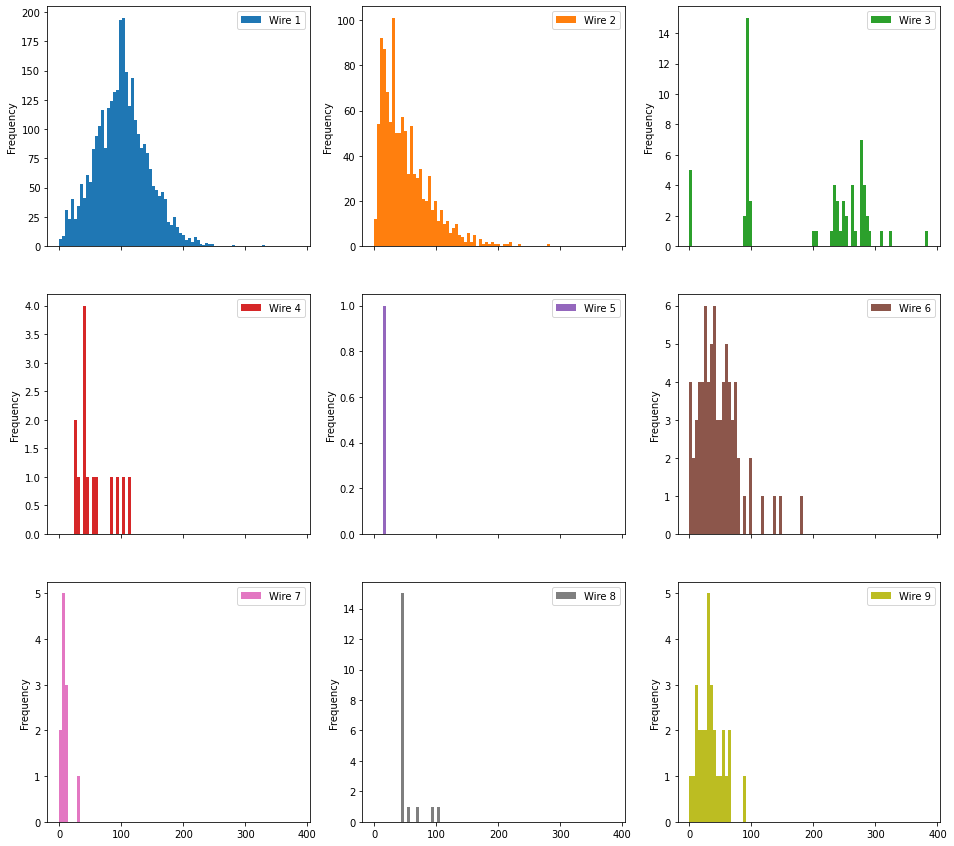

In [ ]:
# Распределения подачи проволочных материлов
data_wire.drop(['key'], axis=1).plot.hist(subplots=True, layout=(3,3), figsize=(16, 15), bins=80)

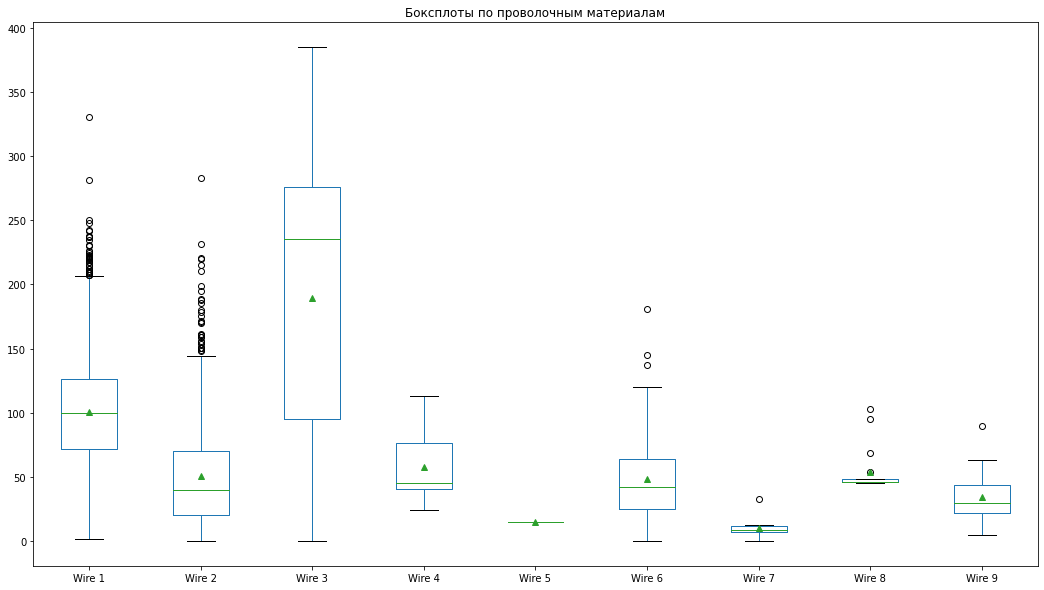

In [ ]:
# Боксплоты по подаче проволочных материлов
data_wire.drop(['key'],axis=1).plot(kind='box', figsize=(18,10), title='Боксплоты по проволочным материалам', showmeans=True)
plt.show()

Из всех проволочных материалов, пожалуй, только распределение Wire 1 напоминает нормальное (со смещением вправо). 
Остальные носят спонтанный анормальный характер с пиками и случайными выбросами.

**Предварительные наблюдения:**
- много пропущенных значений, которые могут связаны с неподачей проволочного материала - можно заполнить нулями
- два проволочных материала используются чаще остальных
- наименование столбцов необходимо привести к змеиному регистру

### Данные о проволочных материалах (время)

In [ ]:
data_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

key               Wire 1 Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7  \
3076  3237  2019-08-31 22:50:20    NaN    NaN    NaN    NaN    NaN    NaN   
3077  3238  2019-08-31 23:38:24    NaN    NaN    NaN    NaN    NaN    NaN   
3078  3239  2019-09-01 01:50:43    NaN    NaN    NaN    NaN    NaN    NaN   
3079  3240  2019-09-01 03:12:02    NaN    NaN    NaN    NaN    NaN    NaN   
3080  3241  2019-09-01 04:16:01    NaN    NaN    NaN    NaN    NaN    NaN   

     Wire 8 Wire 9  
3076    NaN    NaN  
3077    NaN    NaN  
3078    NaN    NaN  
3079    NaN    NaN  
3080    NaN    NaN

key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

Дубликатов 0
Пропущенных значений key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


**Предварительные наблюдения:**
- много пропущенных значений, которые могут связаны с неподачей проволочного материала - можно заполнить нулями
- данные следует привести к типу datetime для дальнейшей работы
- наименование столбцов необходимо привести к змеиному регистру

## Примерный план решения задачи

1. Импортируем данные и проведем исследовательский анализ данных с построением распределений в датасетах
2. Проведем предобработку данных: обработаем пропуски и аномалии, сгенерируем новые признаки и проведем агрегирование по ключу
3. Исследуем объединенный датафрейм и проведем его предобработку с учетом используемых моделей
4. Разделим датафрейм на обучающую и тестовую выборки в соотношении 75:25
5. В случае использования линейных моделей проведем при необходимости масштабирование
6. Применим несколько моделей-регрессоров с подбором гиперпараметров: CatBoost, LightGBM, линейную регрессию
7. Сравним метрики моделей на кросс-валидации и выберем самую успешную
8. Проверим качество модели на тестовой выборке
9. Исследуем важность признаков и подготовим итоговый отчет

## Предобработка данных

In [ ]:
# Изменим тип данных на datetime
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [ ]:
# Удалим аномальный выброс реактивной мощности, оставив только положительные значения
data_arc = data_arc[data_arc['Реактивная мощность'] >= 0]

In [ ]:
# Исследуем последовательность пропущенных значений по температуре
data_temp[data_temp['Температура'].isnull()].head(10)

key        Время замера  Температура
12268  2500 2019-08-06 03:24:43          NaN
12269  2500 2019-08-06 03:25:16          NaN
12270  2500 2019-08-06 03:28:21          NaN
12272  2501 2019-08-06 04:01:59          NaN
12273  2501 2019-08-06 04:14:35          NaN
12274  2501 2019-08-06 04:22:14          NaN
12275  2501 2019-08-06 04:31:14          NaN
12277  2502 2019-08-06 04:46:04          NaN
12278  2502 2019-08-06 04:52:32          NaN
12279  2502 2019-08-06 04:57:30          NaN

In [ ]:
data_temp[data_temp['Температура'].isnull()].tail(10)

key        Время замера  Температура
15896  3240 2019-09-01 03:03:21          NaN
15897  3240 2019-09-01 03:12:19          NaN
15898  3240 2019-09-01 03:19:09          NaN
15899  3240 2019-09-01 03:31:27          NaN
15900  3240 2019-09-01 03:34:31          NaN
15901  3240 2019-09-01 03:35:16          NaN
15903  3241 2019-09-01 04:16:12          NaN
15904  3241 2019-09-01 04:22:39          NaN
15905  3241 2019-09-01 04:33:42          NaN
15906  3241 2019-09-01 04:38:08          NaN

In [ ]:
data_temp[data_temp['Температура'].isnull()].count()

key             2901
Время замера    2901
Температура        0
dtype: int64

По всей видимости по температуре отсутствуют значения, начиная с номера партии key = 2500. Удалим эти пропуски по ключам, начиная с 2500.

In [ ]:
# Создадим новый признак для длительность нагрева (в секундах)
data_arc['Длительность нагрева'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc['Длительность нагрева'] = data_arc['Длительность нагрева'].dt.seconds

In [ ]:
data_temp = data_temp.query('key < 2500')
data_arc = data_arc.query('key < 2500')
data_bulk = data_bulk.query('key < 2500')
data_wire = data_wire.query('key < 2500')

In [ ]:
# Определим число нагревов
data_arc_c = data_arc.groupby(by = 'key', as_index = False).count()[['key', 'Начало нагрева дугой']]
data_arc_c.columns = ['key', 'Число нагревов']

In [ ]:
# Сгруппируем данные по партиям
data_arc = data_arc.groupby(by = 'key', as_index = False).sum()

In [ ]:
# Добавим информацию о числе нагревов по ключу key
data_arc = data_arc.merge(data_arc_c, how = 'left', on = 'key')

In [ ]:
# Корреляция между активной и реактивной мощностями
print('Корреляция активной и реактивной мощности', data_arc['Активная мощность'].corr(data_arc['Реактивная мощность']))

Корреляция активной и реактивной мощности 0.959726916707409


Чтобы исключить такой высокую корреляцию между признаками, введем новый признак полной мощности по формуле корня из суммы квадратов активной и реактивной мощности
$$ S = \sqrt {A^2+R^2} $$

In [ ]:
# Функция по расчету полной мощности
def total_power(row):
    total_power = math.sqrt(row['Активная мощность']**2 + row['Реактивная мощность']**2)
    return total_power

In [ ]:
data_arc['Полная мощность'] = data_arc.apply(total_power, axis=1)

In [ ]:
# Оставим вместо коллинеарной пары признаков активной и реактивной мощности только новый признак полной мощности
data_arc = data_arc[['key', 'Полная мощность', 'Длительность нагрева', 'Число нагревов']]

<Figure size 1080x720 with 0 Axes>

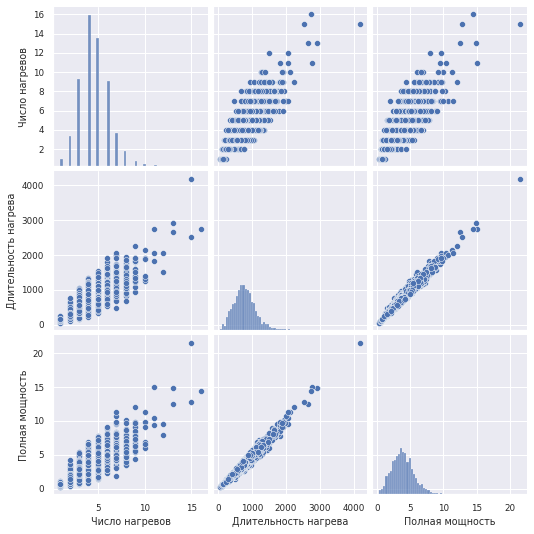

In [ ]:
# Изучим корреляцию текущих признаков
plt.figure(figsize=(15,10))
sns.set(font_scale=0.8)
sns.pairplot(data_arc[['Число нагревов', 'Длительность нагрева', 'Полная мощность']], kind="scatter")
plt.show()

In [ ]:
data_arc[['Полная мощность', 'Длительность нагрева', 'Число нагревов']].corr()

Полная мощность  Длительность нагрева  Число нагревов
Полная мощность              1.000000              0.982962        0.760368
Длительность нагрева         0.982962              1.000000        0.795958
Число нагревов               0.760368              0.795958        1.000000

Заметна очень сильная корреляция между полной мощностью и длительностью нагрева. 
Исключим длительность нагрева из дальнейшего анализа.

In [ ]:
# Исключим столбец по длительности нагрева
data_arc = data_arc[['key', 'Полная мощность', 'Число нагревов']]

In [ ]:
# Удалим пропуски в таблице data_temp
data_temp = data_temp.dropna(subset=['Температура']).reset_index(drop=True)
data_temp = data_temp.sort_values(by=['Время замера'])

In [ ]:
# Исключим партии, по которым известно только одно измерение температуры
count = data_temp.groupby(by = 'key', as_index = False).count()
one = count[count['Время замера'] == 1]['key'].tolist()
data_temp = data_temp.query('key not in @one')

In [ ]:
# Сгруппируем данные партии по первым и последним значениям измерения температуры
data_temp = data_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
data_temp.columns = data_temp.columns.droplevel()
data_temp.columns = ['key', 'Время замера 1', 'Время замера 2', 'Температура 1', 'Температура 2']
data_temp = data_temp[['key', 'Температура 1', 'Температура 2']]

### Объединение данных в единый датасет

In [ ]:
# Проверим партии без добавки сыпучих материалов
no_bulk_added = (set(data_temp.merge(data_bulk, on='key', how='outer').key.unique())
                 - set(data_temp.merge(data_bulk, on='key', how='right').key.unique()))

In [ ]:
# Проверим партии без добавки проволочных материалов
no_wire_added = (set(data_temp.merge(data_wire, on='key', how='outer').key.unique()) 
                 - set(data_temp.merge(data_wire, on='key', how='right').key.unique()))

In [ ]:
# Проверим партии без продувки газа
no_gas_added = (set(data_temp.merge(data_gas, on='key', how='outer').key.unique()) 
                - set(data_temp.merge(data_gas, on='key', how='right').key.unique()))

In [ ]:
no_adds = []
for item in no_gas_added:
    if item in no_wire_added and item in no_bulk_added:
        no_adds.append(item)
        
print(no_adds)

[]


In [ ]:
# Агрегируем данные по ключу key с типом присоединения inner
merged = (data_temp.merge(data_arc, how = 'inner', on = 'key')
                   .merge(data_wire, how = 'inner', on = 'key')
                   .merge(data_bulk, how = 'inner', on = 'key')
                   .merge(data_gas, how = 'inner', on = 'key')
          )

In [ ]:
# Заполним нулями пропуски, возникшие после объединения таблиц
merged = merged.fillna(0)

In [ ]:
merged

key  Температура 1  Температура 2  Полная мощность  Число нагревов  \
0        1         1571.0         1613.0         5.824889               5   
1        2         1581.0         1602.0         3.648398               4   
2        3         1596.0         1599.0         2.989502               5   
3        4         1601.0         1625.0         3.813674               4   
4        5         1576.0         1602.0         4.034596               4   
...    ...            ...            ...              ...             ...   
2324  2495         1570.0         1591.0         3.985197               4   
2325  2496         1554.0         1591.0         5.055976               6   
2326  2497         1571.0         1589.0         2.884756               3   
2327  2498         1591.0         1594.0         4.143362               5   
2328  2499         1569.0         1603.0         4.951128               4   

          Wire 1    Wire 2  Wire 3  Wire 4  Wire 5  ...  Bulk 7  Bulk 8  \
0      60.059998   0.00000     0.0     0.0     0.0  ...     0.0     0.0   
1      96.052315   0.00000     0.0     0.0     0.0  ...     0.0     0.0   
2      91.160157   0.00000     0.0     0.0     0.0  ...     0.0     0.0   
3      89.063515   0.00000     0.0     0.0     0.0  ...     0.0     0.0   
4      89.238236   9.11456     0.0     0.0     0.0  ...     0.0     0.0   
...          ...       ...     ...     ...     ...  ...     ...     ...   
2324   89.150879   0.00000     0.0     0.0     0.0  ...     0.0     0.0   
2325  114.179527   0.00000     0.0     0.0     0.0  ...     0.0     0.0   
2326   94.086723   9.04800     0.0     0.0     0.0  ...     0.0     0.0   
2327  118.110717   0.00000     0.0     0.0     0.0  ...     0.0     0.0   
2328  110.160958  50.00528     0.0     0.0     0.0  ...     0.0     0.0   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15      Газ 1  
0        0.0      0.0      0.0    206.0      0.0    150.0    154.0  29.749986  
1        0.0      0.0      0.0    206.0      0.0    149.0    154.0  12.555561  
2        0.0      0.0      0.0    205.0      0.0    152.0    153.0  28.554793  
3        0.0      0.0      0.0    207.0      0.0    153.0    154.0  18.841219  
4        0.0      0.0      0.0    203.0      0.0    151.0    152.0   5.413692  
...      ...      ...      ...      ...      ...      ...      ...        ...  
2324     0.0     90.0      0.0    256.0      0.0    129.0    223.0   7.125735  
2325     0.0    122.0      0.0    256.0      0.0    129.0    226.0   9.412616  
2326     0.0      0.0      0.0    230.0      0.0    124.0    226.0   6.271699  
2327     0.0    101.0      0.0    206.0      0.0    129.0    207.0  14.953657  
2328     0.0      0.0      0.0    233.0      0.0    126.0    227.0  11.336151  

[2329 rows x 30 columns]

In [ ]:
# Переведем наименование столбцов в змеиный регистр латиницей
merged = merged.rename(columns={'Температура 1': 'first_temp',
                            'Температура 2': 'last_temp',
                            'Полная мощность': 'total_power',
                            'Число нагревов':'heating_number',
                            'Газ 1': 'gas'})

In [ ]:
# Переведем остальные столбцы в змеиный регистр
merged.columns = merged.columns.str.replace(" ", "_")
merged.columns = merged.columns.str.lower()

In [ ]:
# Опустим колонку key, которую мы использовали для слияния датасета
merged = merged.drop(['key'], axis = 1)

In [ ]:
merged.head(5)

first_temp  last_temp  total_power  heating_number     wire_1   wire_2  \
0      1571.0     1613.0     5.824889               5  60.059998  0.00000   
1      1581.0     1602.0     3.648398               4  96.052315  0.00000   
2      1596.0     1599.0     2.989502               5  91.160157  0.00000   
3      1601.0     1625.0     3.813674               4  89.063515  0.00000   
4      1576.0     1602.0     4.034596               4  89.238236  9.11456   

   wire_3  wire_4  wire_5  wire_6  ...  bulk_7  bulk_8  bulk_9  bulk_10  \
0     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0      0.0   
1     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0      0.0   
2     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0      0.0   
3     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0      0.0   
4     0.0     0.0     0.0     0.0  ...     0.0     0.0     0.0      0.0   

   bulk_11  bulk_12  bulk_13  bulk_14  bulk_15        gas  
0      0.0    206.0      0.0    150.0    154.0  29.749986  
1      0.0    206.0      0.0    149.0    154.0  12.555561  
2      0.0    205.0      0.0    152.0    153.0  28.554793  
3      0.0    207.0      0.0    153.0    154.0  18.841219  
4      0.0    203.0      0.0    151.0    152.0   5.413692  

[5 rows x 29 columns]

In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   first_temp      2329 non-null   float64
 1   last_temp       2329 non-null   float64
 2   total_power     2329 non-null   float64
 3   heating_number  2329 non-null   int64  
 4   wire_1          2329 non-null   float64
 5   wire_2          2329 non-null   float64
 6   wire_3          2329 non-null   float64
 7   wire_4          2329 non-null   float64
 8   wire_5          2329 non-null   float64
 9   wire_6          2329 non-null   float64
 10  wire_7          2329 non-null   float64
 11  wire_8          2329 non-null   float64
 12  wire_9          2329 non-null   float64
 13  bulk_1          2329 non-null   float64
 14  bulk_2          2329 non-null   float64
 15  bulk_3          2329 non-null   float64
 16  bulk_4          2329 non-null   float64
 17  bulk_5          2329 non-null   f

После агрегирования данных мы получили набор признаков с целевым признаком last_temp.

## Обучение модели

### Подготовка данных к обучению

Разделим нашу выборку на тестовую и обучающую в соотношении 75:25.

In [ ]:
train, test = train_test_split(merged, test_size = .25, random_state = 190922)

Из-за заметного дисбаланса промасштабируем количественные признаки.

In [ ]:
# Масштабируем количественные признаки
numeric = merged.columns.tolist()
numeric = [i for i in numeric if i not in ('last_temp')]
scaler = MinMaxScaler()
scaler.fit(train[numeric])

MinMaxScaler()

In [ ]:
# Масштабируем обучающую выборку
train[numeric] = scaler.transform(train[numeric])

In [ ]:
# Масштабируем тестовую выборку
test[numeric] = scaler.transform(test[numeric])

In [ ]:
print('Размер обучающей выборки:', train.shape)

Размер обучающей выборки: (1746, 29)


In [ ]:
print('Размер тестовой выборки:', test.shape)

Размер тестовой выборки: (583, 29)


In [ ]:
train.head(5)

first_temp  last_temp  total_power  heating_number    wire_1    wire_2  \
1828    0.847345     1591.0     0.120347        0.214286  0.309039  0.000000   
1500    0.814159     1576.0     0.149553        0.214286  0.111930  0.106442   
1289    0.856195     1585.0     0.170698        0.214286  0.605129  0.212671   
463     0.803097     1591.0     0.161101        0.214286  0.303202  0.000000   
1362    0.944690     1621.0     0.245853        0.428571  0.733069  0.000000   

        wire_3  wire_4  wire_5  wire_6  ...  bulk_7  bulk_8  bulk_9  bulk_10  \
1828  0.000492     0.0     0.0     0.0  ...     0.0     0.0     0.0      0.0   
1500  0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0      0.0   
1289  0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0      0.0   
463   0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0      0.0   
1362  0.000000     0.0     0.0     0.0  ...     0.0     0.0     0.0      0.0   

      bulk_11   bulk_12  bulk_13   bulk_14   bulk_15       gas  
1828      0.0  0.099513      0.0  0.204403  0.306173  0.120959  
1500      0.0  0.084370      0.0  0.314465  0.259259  0.052000  
1289      0.0  0.000000      0.0  0.405660  0.506173  0.143489  
463       0.0  0.154137      0.0  0.202830  0.555556  0.091369  
1362      0.0  0.222823      0.0  0.316038  0.506173  0.148836  

[5 rows x 29 columns]

**Выполненные шаги по подготовке данных к обучению модели**
- Проведена предобработка данных
- Удалены выбросы и пропущенные значения
- Данные агрегированы в единый датасет
- Датасет разделен на обучающую и тестовую выборку в отношении 0.75 : 0.25
- Проведено масштабирование признаков для линейной модели

### Обучение моделей с подбором гиперпараметров

In [ ]:
# Выделим признаки для обучающей выборки
features_train = train.drop(['last_temp'], axis = 1)
target_train = train['last_temp']

In [ ]:
# Выделим признаки для тестовой выборки
features_test = test.drop(['last_temp'], axis = 1)
target_test = test['last_temp']

#### Линейная регрессия

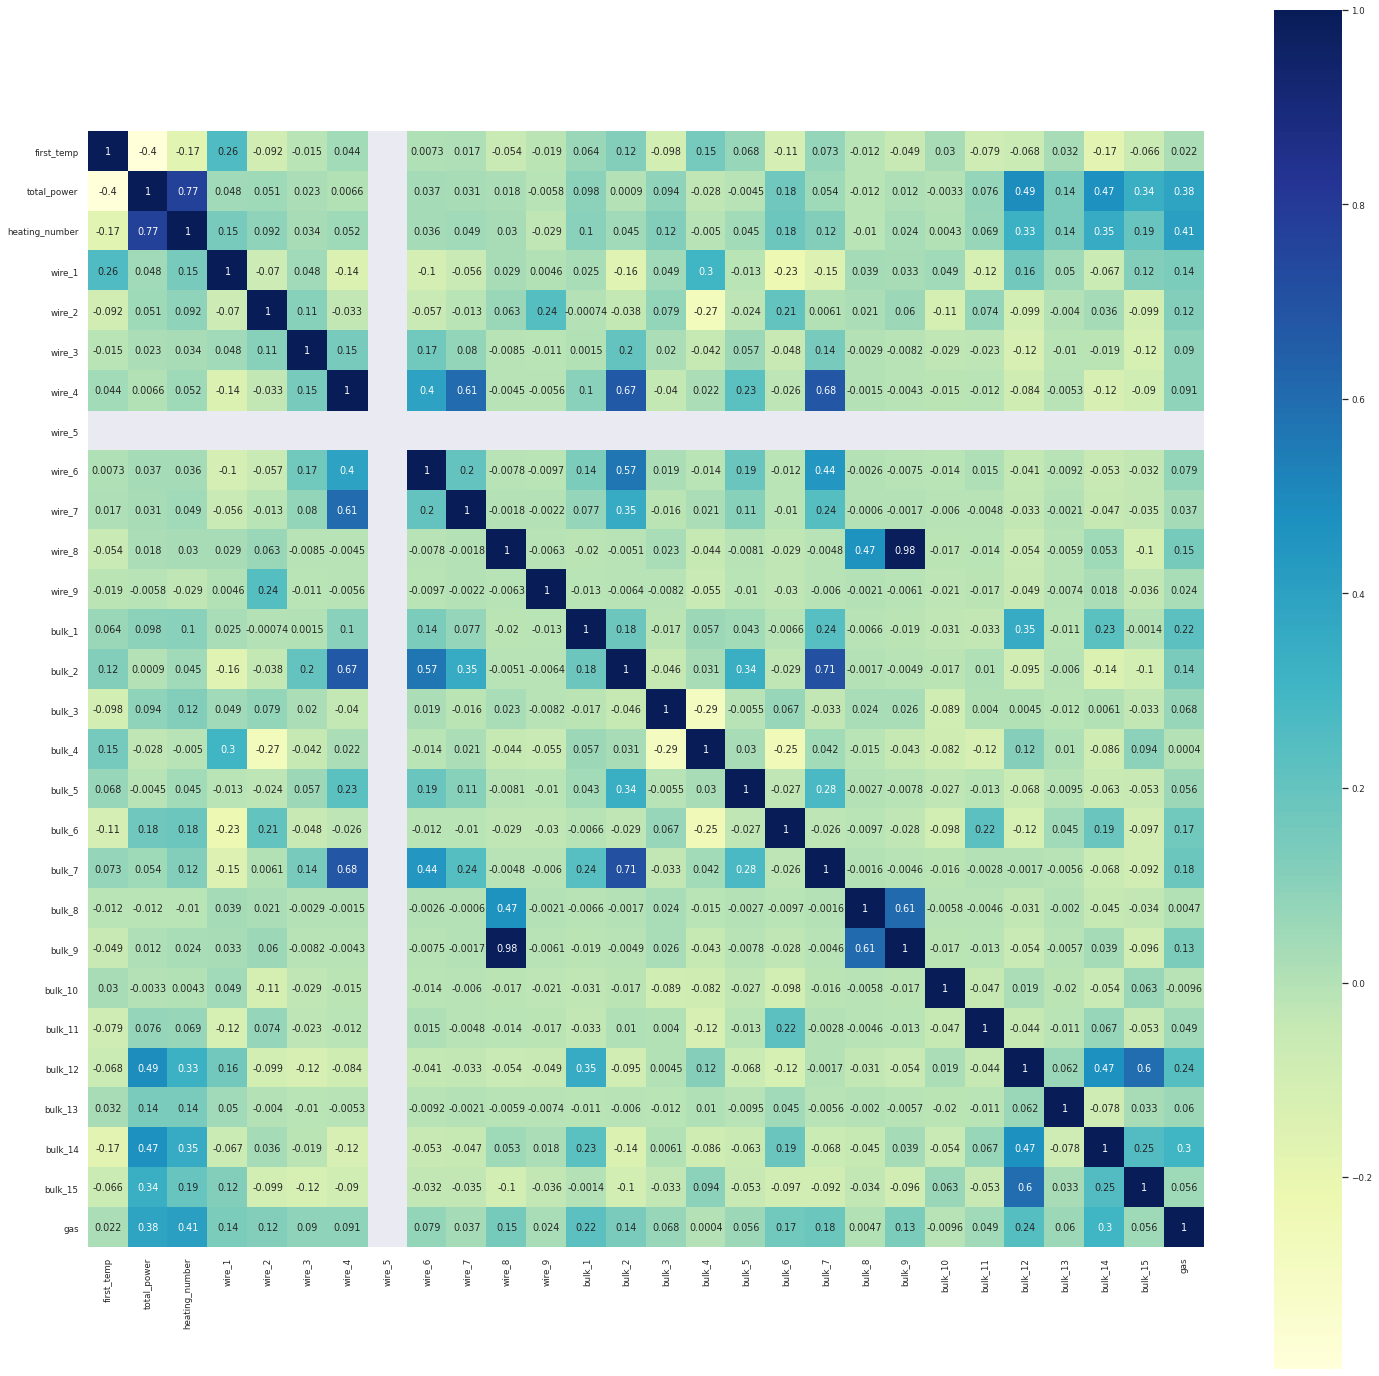

In [ ]:
# Построим тепловую карту для проверки мультиколлинеарности признаков 
f, ax = plt.subplots(figsize=(25, 25))
x = sns.heatmap(features_train.corr(), cmap="YlGnBu", annot=True, square=True)
plt.show()

Судя по тепловой карте и коэффициентам, сильную корреляцию (0.98) показывают признаки wire_8 и bulk_9. Исключим один из них из дальнейшей работы.

In [ ]:
features_train = features_train.drop(['bulk_9', 'wire_5'], axis = 1)
features_test = features_test.drop(['bulk_9', 'wire_5'], axis = 1)

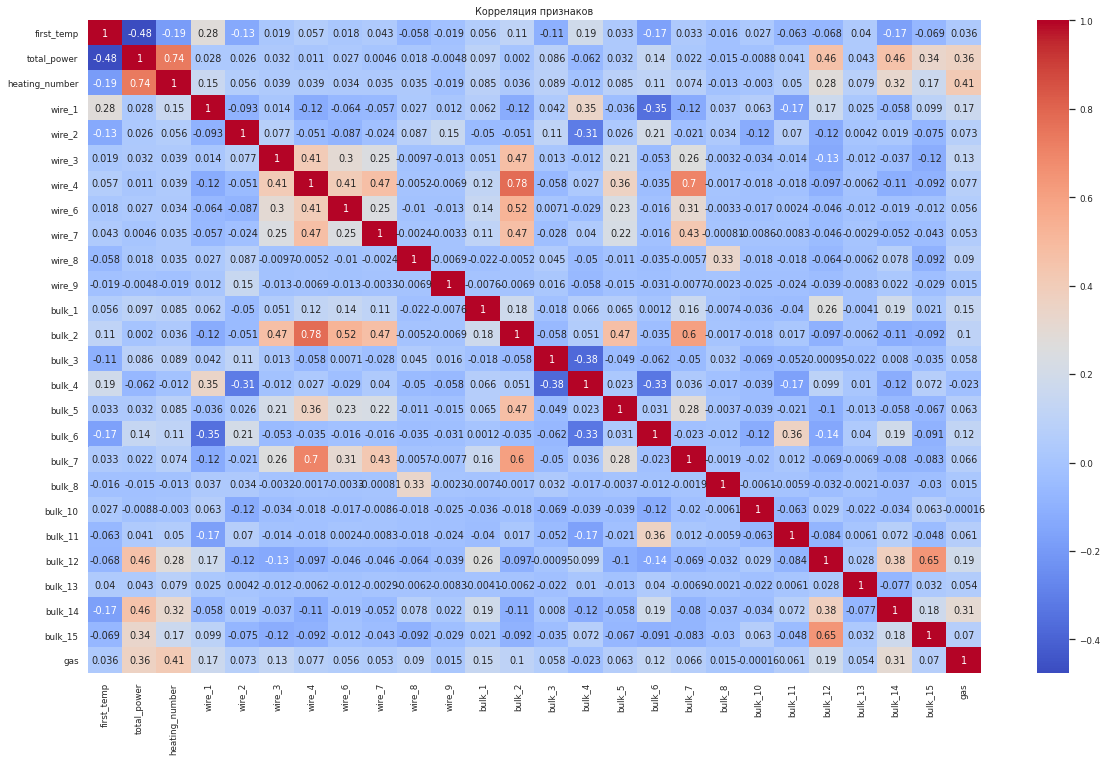

In [ ]:
plt.figure(figsize=(20, 12))
plt.title('Корреляция признаков')
sns.heatmap(features_train.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

In [ ]:
features_train.shape

(1746, 26)

In [ ]:
features_test.shape

(583, 26)

In [ ]:
1746+583

2329

In [ ]:
model_lr = LinearRegression()
mae_train_lr = abs(cross_val_score(model_lr, features_train, target_train, cv=5, 
                                   scoring='neg_mean_absolute_error').mean())

print('MAE на кросс-валидации для модели линейной регрессии', round(mae_train_lr, 3))

MAE на кросс-валидации для модели линейной регрессии 6.757


#### Модель CatBoostRegressor

In [ ]:
regressor = CatBoostRegressor() 
hyperparams = [{
                'n_estimators': [300, 700, 100], 
                'learning_rate': [0.01, 0.05, 0.1],
                'depth': range(4, 10, 2)
              }]

# Подбор гиперпараметров по средней абсолютной ошибке
cbr = GridSearchCV(regressor, hyperparams, cv=5, scoring='neg_mean_absolute_error')
cbr.fit(features_train, target_train)
cbr.best_score_

0:	learn: 10.8927449	total: 48.1ms	remaining: 14.4s
1:	learn: 10.8679672	total: 49.6ms	remaining: 7.39s
2:	learn: 10.8441201	total: 50.9ms	remaining: 5.04s
3:	learn: 10.8176965	total: 52.5ms	remaining: 3.89s
4:	learn: 10.7942957	total: 54.5ms	remaining: 3.22s
5:	learn: 10.7700842	total: 56.5ms	remaining: 2.77s
6:	learn: 10.7437614	total: 58.3ms	remaining: 2.44s
7:	learn: 10.7228772	total: 60ms	remaining: 2.19s
8:	learn: 10.7003319	total: 61.4ms	remaining: 1.99s
9:	learn: 10.6749528	total: 62.7ms	remaining: 1.82s
10:	learn: 10.6534939	total: 64.2ms	remaining: 1.69s
11:	learn: 10.6304876	total: 65.5ms	remaining: 1.57s
12:	learn: 10.6073407	total: 66.6ms	remaining: 1.47s
13:	learn: 10.5857031	total: 67.8ms	remaining: 1.39s
14:	learn: 10.5647285	total: 69.1ms	remaining: 1.31s
15:	learn: 10.5511375	total: 70.4ms	remaining: 1.25s
16:	learn: 10.5371187	total: 71.6ms	remaining: 1.19s
17:	learn: 10.5159313	total: 72.8ms	remaining: 1.14s
18:	learn: 10.4973572	total: 74.1ms	remaining: 1.09s
19:	l

-6.010829829002001

#### Модель LightGBM

In [ ]:
regressor = LGBMRegressor() 
hyperparams = [{'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
                'learning_rate': [0.001, 0.01, 0.02, 0.03],
                #'num_iterations' = 200,
                'max_depth': np.arange(2, 10)   
               }]

# Подбор гиперпараметров по средней абсолютной ошибке
lgbm = GridSearchCV(regressor, hyperparams, cv=5, scoring='neg_mean_absolute_error')
lgbm.fit(features_train, target_train)
lgbm.best_score_

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check 

-6.125812472767381

#### Модель случайного леса

In [ ]:
regressor = RandomForestRegressor() 
hyperparams = [{'n_estimators': [x for x in range(1,501,40)],
                'max_depth': [x for x in range(1, 10, 1)]
               }]

# Подбор гиперпараметров по средней абсолютной ошибке
rfr = GridSearchCV(regressor, hyperparams, cv=5, scoring='neg_mean_absolute_error')
rfr.fit(features_train, target_train)
rfr.best_score_

-6.143841966800952

#### Сводная таблица результатов работы моделей

In [ ]:
# Таблица итоговых результатов с метриками качества моделей
scores = pd.DataFrame(data={'MAE на обучающей выборке':[
                                                    abs(rfr.best_score_),
                                                    abs(cbr.best_score_),
                                                    abs(lgbm.best_score_),
                                                    mae_train_lr]},
                            index=[
                                   'Случайный лес',
                                   'CatBoost',
                                   'LightGBM',
                                   'Линейная регрессия'])
scores

MAE на обучающей выборке
Случайный лес                       6.143842
CatBoost                            6.010830
LightGBM                            6.125812
Линейная регрессия                  6.756741

 **Вывод:**

Рассмотрены четыре модели: линейная регрессия, CatBoost, LightGBM и случайный лес.
На обучающей выборке по метрике MAE получены следующие результаты:

1. CatBoost: MAE = 6.01
2. LightGBM: MAE = 6.12
3. Случайный лес: MAE = 6.14
4. Самый слабый результат показала линейная регрессия с результатом 6.76 на обучающей выборке.

## Проверка качества модели

### Проверка модели на адекватность

In [ ]:
# Проверка гиперпараметров для модели CatBoost
hyperparams = [{
                'n_estimators': [300, 700, 100], 
                'learning_rate': [0.01, 0.05, 0.1],
                'depth': range(4, 10, 2)
              }]

# Подбор гиперпараметров по средней абсолютной ошибке
cbr = GridSearchCV(CatBoostRegressor(), hyperparams, cv=5, scoring='neg_mean_absolute_error')
cbr.fit(features_train, target_train)
cbr.best_params_

0:	learn: 10.8927449	total: 1.38ms	remaining: 412ms
1:	learn: 10.8679672	total: 2.76ms	remaining: 411ms
2:	learn: 10.8441201	total: 4.06ms	remaining: 402ms
3:	learn: 10.8176965	total: 5.3ms	remaining: 392ms
4:	learn: 10.7942957	total: 6.61ms	remaining: 390ms
5:	learn: 10.7700842	total: 7.94ms	remaining: 389ms
6:	learn: 10.7437614	total: 9.23ms	remaining: 386ms
7:	learn: 10.7228772	total: 10.4ms	remaining: 381ms
8:	learn: 10.7003319	total: 11.7ms	remaining: 379ms
9:	learn: 10.6749528	total: 13ms	remaining: 378ms
10:	learn: 10.6534939	total: 14.3ms	remaining: 375ms
11:	learn: 10.6304876	total: 15.6ms	remaining: 374ms
12:	learn: 10.6073407	total: 17ms	remaining: 375ms
13:	learn: 10.5857031	total: 18.2ms	remaining: 372ms
14:	learn: 10.5647285	total: 19.4ms	remaining: 369ms
15:	learn: 10.5511375	total: 20.7ms	remaining: 368ms
16:	learn: 10.5371187	total: 22ms	remaining: 366ms
17:	learn: 10.5159313	total: 23.3ms	remaining: 365ms
18:	learn: 10.4973572	total: 24.7ms	remaining: 365ms
19:	learn:

{'depth': 6, 'learning_rate': 0.05, 'n_estimators': 300}

In [ ]:
# Проверка качества модели CatBoost на тестовой выборке
model = CatBoostRegressor(n_estimators = 300, learning_rate=0.05, depth=6)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print('MAE на тестовой выборке:', mean_absolute_error(predictions, target_test))

0:	learn: 11.0310698	total: 2.89ms	remaining: 864ms
1:	learn: 10.8870025	total: 6.73ms	remaining: 1s
2:	learn: 10.7613527	total: 10.7ms	remaining: 1.05s
3:	learn: 10.6438249	total: 14.1ms	remaining: 1.04s
4:	learn: 10.5060673	total: 17ms	remaining: 1s
5:	learn: 10.3886769	total: 19.8ms	remaining: 971ms
6:	learn: 10.2802366	total: 22.8ms	remaining: 955ms
7:	learn: 10.1820818	total: 26ms	remaining: 949ms
8:	learn: 10.0725567	total: 28.9ms	remaining: 935ms
9:	learn: 9.9957690	total: 31.9ms	remaining: 925ms
10:	learn: 9.8922932	total: 34.8ms	remaining: 913ms
11:	learn: 9.7996187	total: 37.5ms	remaining: 900ms
12:	learn: 9.7072922	total: 40.6ms	remaining: 896ms
13:	learn: 9.6410900	total: 43.4ms	remaining: 887ms
14:	learn: 9.5768703	total: 46.1ms	remaining: 875ms
15:	learn: 9.5069111	total: 49.4ms	remaining: 877ms
16:	learn: 9.4242117	total: 52.4ms	remaining: 873ms
17:	learn: 9.3595401	total: 55.3ms	remaining: 867ms
18:	learn: 9.2995451	total: 58.3ms	remaining: 862ms
19:	learn: 9.2290508	to

In [ ]:
# Запустим дамми-модель для проверки качества
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
predictions = dummy_regr.predict(features_test)

print('MAE на дамми-модели:', mean_absolute_error(predictions, target_test))

MAE на дамми-модели: 8.054842335040737


Проверка на адекватность самой успешной модели (случайного леса) пройдена. Дамми модель дает показатель ошибки выше (8.05 > 5.82 по MAE).

### Важность признаков для работы модели

0:	learn: 11.0391833	total: 3.43ms	remaining: 1.03s
1:	learn: 10.8984954	total: 6.73ms	remaining: 1s
2:	learn: 10.7769086	total: 9.81ms	remaining: 971ms
3:	learn: 10.6556500	total: 13ms	remaining: 959ms
4:	learn: 10.5403161	total: 16ms	remaining: 947ms
5:	learn: 10.4257500	total: 19ms	remaining: 932ms
6:	learn: 10.3160346	total: 22ms	remaining: 922ms
7:	learn: 10.2280759	total: 25ms	remaining: 912ms
8:	learn: 10.1133635	total: 28ms	remaining: 906ms
9:	learn: 10.0217787	total: 31.1ms	remaining: 901ms
10:	learn: 9.9278927	total: 34.1ms	remaining: 895ms
11:	learn: 9.8461419	total: 37ms	remaining: 889ms
12:	learn: 9.7524389	total: 40ms	remaining: 882ms
13:	learn: 9.6790053	total: 42.9ms	remaining: 876ms
14:	learn: 9.5980138	total: 46.1ms	remaining: 875ms
15:	learn: 9.5425796	total: 49.2ms	remaining: 873ms
16:	learn: 9.4714606	total: 52.1ms	remaining: 867ms
17:	learn: 9.4084093	total: 55.2ms	remaining: 864ms
18:	learn: 9.3411782	total: 58ms	remaining: 858ms
19:	learn: 9.2844543	total: 61.1m

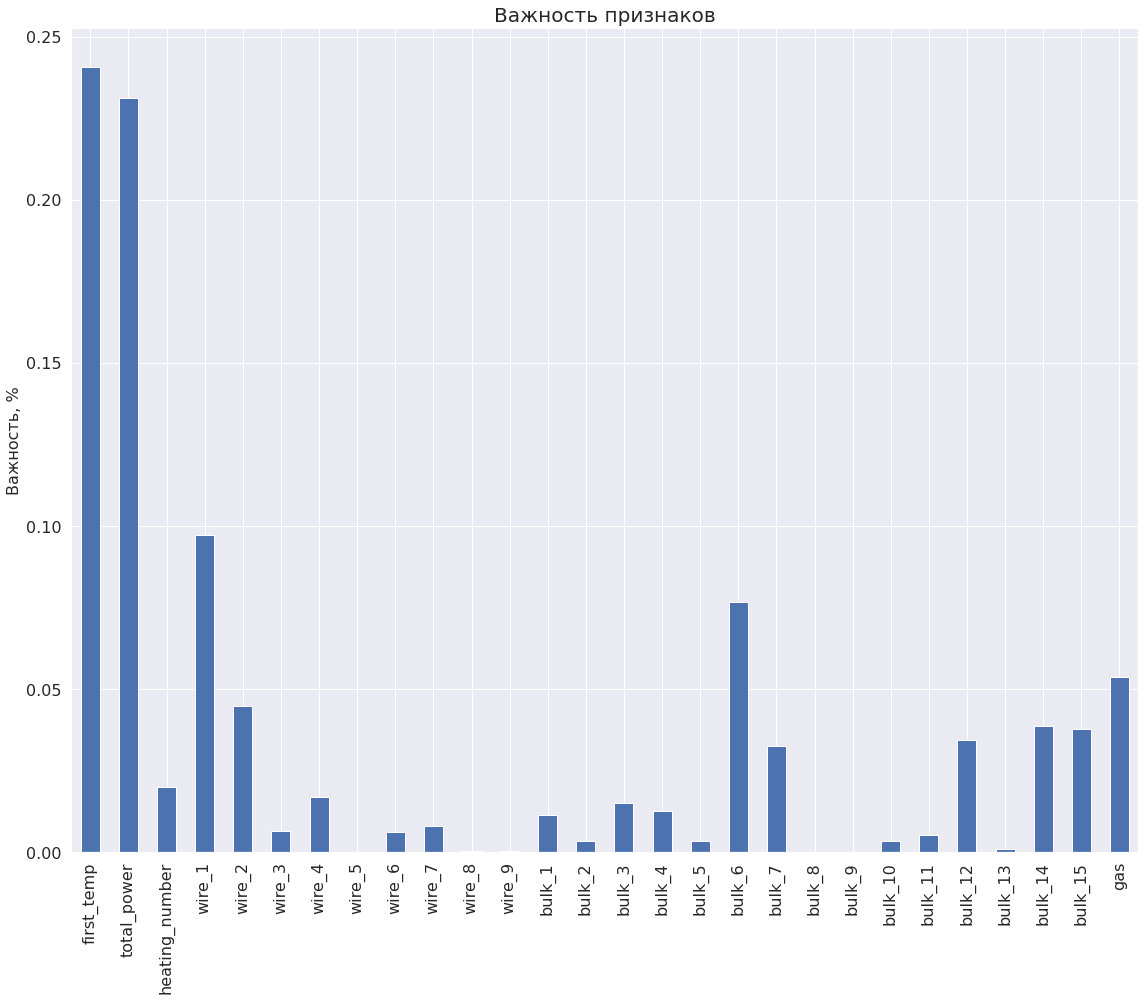

In [ ]:
# Проверка важности признаков для модели случайного леса
model_cbr = CatBoostRegressor(n_estimators = 300, learning_rate = 0.05, depth=6)
model_cbr.fit(X = merged.drop('last_temp', axis=1),
              y = merged['last_temp'])

cbr_imp = pd.Series(model_cbr.get_feature_importance(),
                         merged.drop(['last_temp'], axis=1).columns)
fig, ax = plt.subplots(figsize=(16,14))
rfr_imp.plot.bar(ax=ax, fontsize=16)
ax.set_title("Важность признаков", fontsize=20)
ax.set_ylabel('Важность, %', fontsize=16)
fig.tight_layout()

Самыми важными признаками выбранной модели оказались начальная температура, полная мощность, подача проволочного материала Wire 1 и сыпучего материала bulk 6.

## Общий вывод

* Проведен исследовательский анализ данных с построением распределений в датасетах.
* Данные прошли предобработку: обработаны пропуски и аномалии, сгенерированы новые признаки и проведено агрегирование по ключу.
* Объединенный датафрейм разделен на обучающую и тестовую выборки в соотношении 75:25.
* Для линейной регрессии проведено масштабирование и анализ мультиколлинеарности признаков.
* Запущены в работу несколько моделей-регрессоров с подбором гиперпараметров: CatBoost, LightGBM, случайный лес.
* При сравнении моделей на кросс-валидации выбрана самая успешная - модель CatBoost с гиперпараметрами: n_estimators = 300, learning_rate=0.05, depth = 6.
* На тестовой выборке лучшая модель CatBoost показала результат MAE 5.82, что ниже показателя ошибки наивной дамми-модели (MAE=8.1).
* По анализу важности признаков наибольшее влияние на работу выбранной модели CatBoost оказывает начальная температура, полная мощность, подача проволочного материала Wire 1 и сыпучего материала bulk 6.